In [1]:
import pandas as pd
import numpy as np
import openpyxl
import os
import glob
import matplotlib.pyplot as plt

e:\Installation\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
e:\Installation\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
def read_excel(file):
    df = pd.read_excel(file)
    return df

df = read_excel('../../Data/Processed data/hfrc.xlsx')

In [3]:
# convert Date field to float
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].values.astype(float)
#sort by date
df = df.sort_values(by='Date')
# for rows where df['Affected'] is null or non-numeric, replace with 0
df['Affected'] = pd.to_numeric(df['Affected'], errors='coerce').fillna(0).astype(float)
df.reset_index(drop=True, inplace=True)

In [4]:
# defining hyperparameters
num_epochs = 500
learning_rate = 0.001
batch_size = 32
window_size = 14
input_size = window_size - 1
hidden_size = 64
num_layers = 1

print("num_epochs: ", num_epochs, " learning_rate: ", learning_rate, " batch_size: ", batch_size, " window_size: ", window_size, " input_size: ", input_size, " num_layers: ", num_layers)

num_epochs:  500  learning_rate:  0.001  batch_size:  32  window_size:  14  input_size:  13  num_layers:  1


In [5]:

def create_time_series_samples(df, window_size):
    samples = []

    for i in range(len(df) - window_size + 1):
        sample = df.iloc[i:i + window_size]
        samples.append(sample)

    return samples



samples = create_time_series_samples(df, window_size)

In [6]:
affected_df = pd.DataFrame([sample['Affected'].values for sample in samples])
affected_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,8.0,7.0,8.0,6.0,7.0,7.0,0.0,5.0,4.0,6.0,4.0,5.0,6.0,5.0
1,7.0,8.0,6.0,7.0,7.0,0.0,5.0,4.0,6.0,4.0,5.0,6.0,5.0,5.0
2,8.0,6.0,7.0,7.0,0.0,5.0,4.0,6.0,4.0,5.0,6.0,5.0,5.0,3.0
3,6.0,7.0,7.0,0.0,5.0,4.0,6.0,4.0,5.0,6.0,5.0,5.0,3.0,0.0
4,7.0,7.0,0.0,5.0,4.0,6.0,4.0,5.0,6.0,5.0,5.0,3.0,0.0,3.0


In [7]:
def train_test_split(df, split_ratio, shuffle):
    if shuffle:
        df = df.sample(frac=1)

    split_index = int(len(df) * split_ratio)
    train = df[:split_index]
    test = df[split_index:]

    return train, test

train_df , test_df = train_test_split(affected_df, 0.8, True)

In [8]:
def split_X_y(df):
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    return X, y

X_train, y_train = split_X_y(train_df)
X_test, y_test = split_X_y(test_df)

In [9]:
# Run transformer model from pytorch on Train and Test data
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(y_train.values).float()
X_test_tensor = torch.tensor(X_test.values).float()
y_test_tensor = torch.tensor(y_test.values).float()


In [10]:
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

In [11]:
len(train_loader), len(test_loader)

(18, 5)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define the transformer model architecture
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(TransformerModel, self).__init__()
        self.transformer = nn.Transformer(input_size, nhead=input_size, num_encoder_layers=num_layers)
        self.fc = nn.Linear(input_size, 1)

    def forward(self, x):
        x = self.transformer(x)
        x = self.fc(x)
        return x

# Define the hyperparameters
input_size = window_size - 1
hidden_size = 64
num_layers = 2
num_epochs = 100
learning_rate = 0.001
batch_size = 32

# Create the model
model = TransformerModel(input_size, hidden_size, num_layers)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create data loaders for training and testing
train_loader = DataLoader(train_df, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_df, batch_size=batch_size, shuffle=False)

# Train the model
for epoch in range(num_epochs):
    model.train()
    for X, y in train_loader:
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y.unsqueeze(1))
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    total_loss = 0
    for X, y in test_loader:
        outputs = model(X)
        loss = criterion(outputs, y.unsqueeze(1))
        total_loss += loss.item() * X.size(0)

    average_loss = total_loss / len(test_loader.dataset)
    print(f'Test Loss: {average_loss:.4f}')

# Make predictions using the trained model
model.eval()
predictions = []
with torch.no_grad():
    for X, y in test_loader:
        outputs = model(X)
        predictions.extend(outputs.squeeze(1).tolist())

# Plot the predictions and actual values
plt.figure(figsize=(14, 8))
plt.plot(y_test.values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()


KeyError: 132

In [ ]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
#train the model
for epoch in range(num_epochs):
    for i, (X, y) in enumerate(train_loader):
        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y.unsqueeze(1))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [50/500], Loss: 24.8288
Epoch [100/500], Loss: 0.5073
Epoch [150/500], Loss: 0.9673
Epoch [200/500], Loss: 3.2598
Epoch [250/500], Loss: 1.4115
Epoch [300/500], Loss: 13.6256
Epoch [350/500], Loss: 0.4463
Epoch [400/500], Loss: 10.9207
Epoch [450/500], Loss: 1.2013
Epoch [500/500], Loss: 9.1680


In [ ]:
# Test the model
predictions = []
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for X, y in test_loader:
        outputs = model(X)
        predicted = torch.round(outputs)
        predictions.append(predicted)
        total += y.size(0)
        correct += (predicted == y.unsqueeze(1)).sum().item()

    print('Test Accuracy of the model on the test data: {} %'.format(100 * correct / total))

Test Accuracy of the model on the test data: 19.708029197080293 %


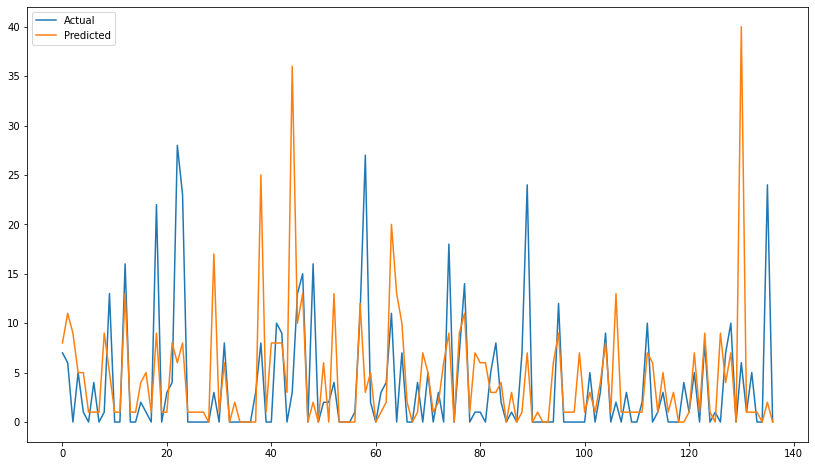

In [ ]:
#plot the predictions and actual 
plt.figure(figsize=(14, 8))
plt.plot(y_test.values, label='Actual')
plt.plot(torch.cat(predictions).numpy(), label='Predicted')
plt.legend()
plt.show()